In [5]:
from src import params
from src.data_preprocess import utils
from collections import Counter
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import ast

df_codebook_final = pd.read_csv(f'{str(params.codebook_path).replace("src/data_preprocess/","")}/UKB_preprocess_codebook_wave_0_final.csv')
df_standard= pd.read_pickle(f'{str(params.final_data_path ).replace("src/data_preprocess/","")}/UKB_wave_0_final_standardised.pkl')

df = pd.read_pickle(f'{str(params.final_data_path ).replace("src/data_preprocess/","")}/UKB_wave_0_final_non_standardised.pkl')
record_column = params.disease_record_column
access_date_column = '53'
HES_ICD_ids = params.HES_ICD_ids
level = 'chronic_cate'
weight_control = False

# control zone
chapter_ranges = [x for x in range(1, 16)]+[19] if 'chapter' in level else [x for x in range(1, 18)]
# disease_column = params.disease_columns_dict[level]
disease_columns = ['diseases_within_window_phecode_selected_chronic_first_occ','diseases_within_window_phecode_selected_category_chronic_first_occ']
df_single_record = pd.read_csv(f'{str(params.intermediate_path).replace("src/data_preprocess/","")}/{params.disease_record_column}_complete.csv')


/var/folders/04/q8s7l0r939g8fqqljjn3_rbm0000gn/T/ipykernel_48224/2448405963.py:24: DtypeWarning: Columns (113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264) have mixed types. Specify dtype option on import or set low_memory=False.
  df_single_record = pd.read_csv(f'{str(params.intermediate_path).replace("src/data_preprocess/","")}/{params.disease_record_column}_complete.csv')


In [6]:
phe_cate_dict = {y:x for x,y in params.phe_cate_dict.items()}

disease_column = disease_columns[1]

# merge weight to the dataframe
if weight_control:
    df = pd.merge(df, df_single_record[['eid', 'weight']], how='left', left_on='eid', right_on='eid')
#    average disease count by age and gender
    df[f'{level}_disease_count'] = [len(x)*weight if str(x) not in params.nan_str else 0 for x,weight in zip(df[disease_column],df['weight'])]
else:

    df_single_record[disease_column] = [ast.literal_eval(x) if str(x) not in params.nan_str else None for x in df_single_record[disease_column]]
    df = df.merge(df_single_record[['eid', disease_column]], how='left', left_on='eid', right_on='eid')
    df[f'{level}_disease_count'] = [len(x) if str(x) not in params.nan_str else 0 for x in df[disease_column]]

## Average diseases count

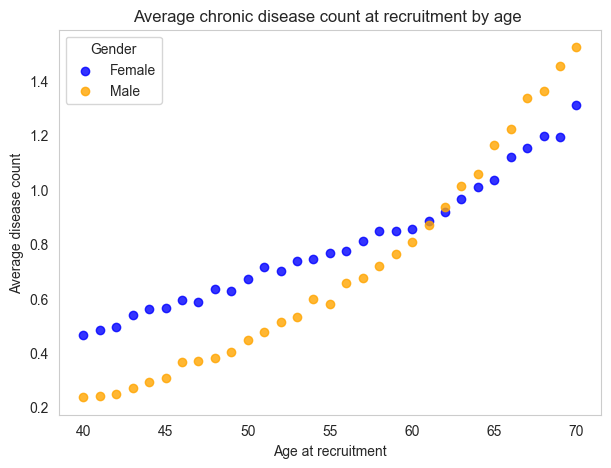

In [8]:
df_to_plot = df[[disease_column,f'{level}_disease_count', '31', '21022']].copy()
# 31: gender
# 21022: age at recruitment
# display the disease count by gender and age
df_to_plot = df_to_plot.groupby(['31', '21022']).agg(cases_count=(f'{level}_disease_count', 'count'), disease_count=(f'{level}_disease_count', 'mean')).reset_index()
# set 31 as categorical variable
df_to_plot['31'] = df_to_plot['31'].astype('category')
df_to_plot['31'] = df_to_plot['31'].cat.rename_categories(['Female', 'Male'])
df_to_plot = df_to_plot.loc[(df_to_plot['21022']>=40) & (df_to_plot['21022']<=70),] # delete 40 and 70 as they are severe underpresented


fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [7,5]
# Colors to use for the two categories (adjust as needed)
colors = ['blue', 'orange']
# Plot each category with its own color and label
for i, category in enumerate(df_to_plot['31'].cat.categories):
    df_subset = df_to_plot[df_to_plot['31'] == category]
    ax.scatter(df_subset['21022'], df_subset['disease_count'], color=colors[i], label=category,alpha=0.8)

ax.grid(False)
# Add a legend
ax.legend(title='Gender')
plt.title(f'Average chronic disease count at recruitment by age {"(weighted)" if weight_control else ""}')
plt.xlabel('Age at recruitment')
plt.ylabel('Average disease count')
plt.show()
# plt.savefig(params.current_path/f'plot/{level}/average_disease_count_at_recruitment_{record_column}_{"weighted" if weight_control else ""}.pdf')


# disease chapter count by age and gender


In [10]:
# mark the chapter of the diseases
def count_chapter(row):
    """
    count the chapter of the diseases for each row in the dataframe
    """
    if str(row[disease_column]) not in ['None','nan','NaN']:
        chapters = [str(x) for x in row[disease_column]]
        count_dict = Counter(chapters)
        if 'weight' in row.index.tolist():
            count_dict = {k: v*row['weight'] for k, v in count_dict.items()}
    else:
        count_dict = None
    return count_dict

if weight_control:
    df_to_plot = df[[disease_column, '31', '21022','weight']].copy()
else:
    df_to_plot = df[[disease_column, '31', '21022']].copy()

# separate diseases by the chapter name (each chapter will have a separate column)
df_to_plot['chapter_count'] = df_to_plot.apply(count_chapter, axis=1)

chapter_ranges = df[df[disease_column].notnull()][disease_column].apply(lambda x: [int(y) for y in x]).explode().dropna().unique()
chapter_ranges.sort()
for column in chapter_ranges:
    df_to_plot[f'chapter_{column}'] = [x[str(column)] if isinstance(x, dict) and str(column) in x.keys() else None for x in df_to_plot['chapter_count']]


df_plot_2 = df_to_plot.pivot_table(index=['21022', '31'],  values=[f'chapter_{x}' for x in chapter_ranges], aggfunc='sum').reset_index()
# remove sparse data points that have age below 40 or over 70 (same as the last plot)
df_plot_2.drop(df_plot_2.loc[(df_plot_2['21022'] < 40) | (df_plot_2['21022'] > 70)].index, inplace=True)

# set 31 as categorical variable
df_plot_2['31'] = df_plot_2['31'].astype('category')
df_plot_2['31'] = df_plot_2['31'].cat.rename_categories(['Female', 'Male'])


## absolute counts of the diseases

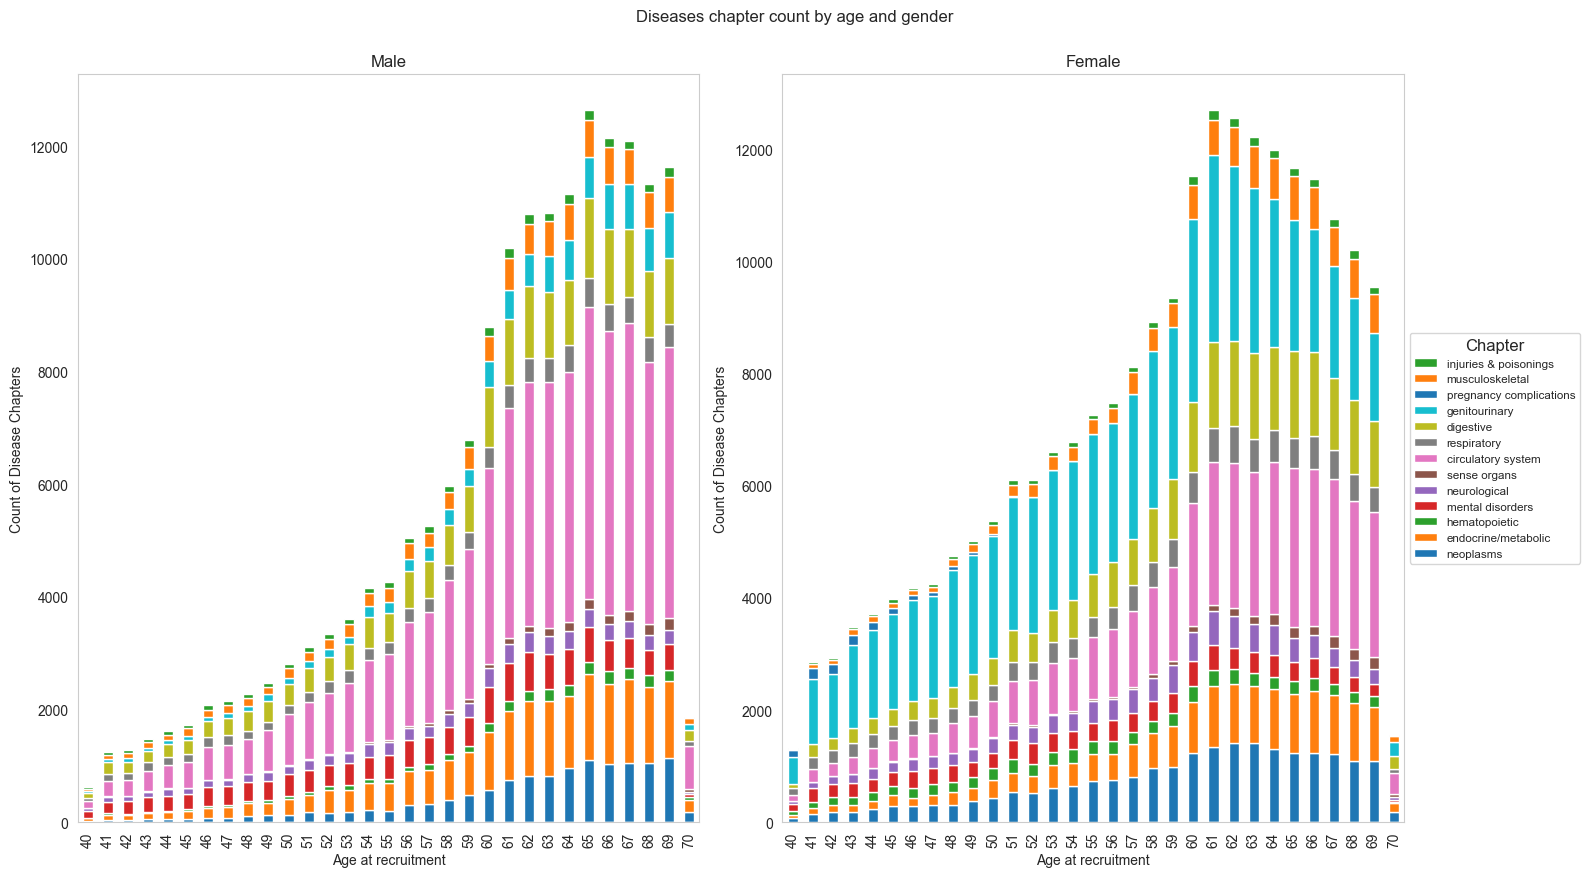

In [12]:


fig, (ax1, ax2) = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [16,9]
# Create a subset of the dataframe with only the columns to be plotted
gender = 'Male'
df_subset = df_plot_2[df_plot_2['31'] == gender][['21022'] + [f'chapter_{i}' for i in chapter_ranges]]
# Set '21022' as the index to be used as x-axis
df_subset.set_index('21022', inplace=True)
# Plot the stacked bar chart
df_subset.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title(gender)
ax1.set_xlabel('Age at recruitment')
ax1.set_ylabel('Count of Disease Chapters')
# remove the legend
ax1.get_legend().remove()

gender = 'Female'
df_subset = df_plot_2[df_plot_2['31'] == gender][['21022'] + [f'chapter_{i}' for i in chapter_ranges]]
# Set '21022' as the index to be used as x-axis
df_subset.set_index('21022', inplace=True)

# Plot the stacked bar chart
df_subset.plot(kind='bar', stacked=True,  ax=ax2)
ax2.set_title(gender)
ax2.set_xlabel('Age at recruitment')
ax2.set_ylabel('Count of Disease Chapters')


handles, labels = ax2.get_legend_handles_labels()  # reverse the order of legend
labels = [phe_cate_dict[int(str(x).replace('chapter_',''))] for x in labels]

ax2.legend(reversed(handles), reversed(labels), title='Chapter', title_fontsize='large', fontsize='small', loc='center left', bbox_to_anchor=(1.0, 0.5))

for ax in [ax1, ax2]:
    ax.grid(False)
# fig.suptitle('Diseases chapter count by age and gender')
fig.tight_layout(rect=[0, 0.01, 1, 0.98])
# plt.show()

# plt.savefig(params.current_path/f'plot/{level}/diseases_chapter_count_{record_column}_by_age_and_gender{"_weighted" if weight_control else ""}.pdf')


## proportional view


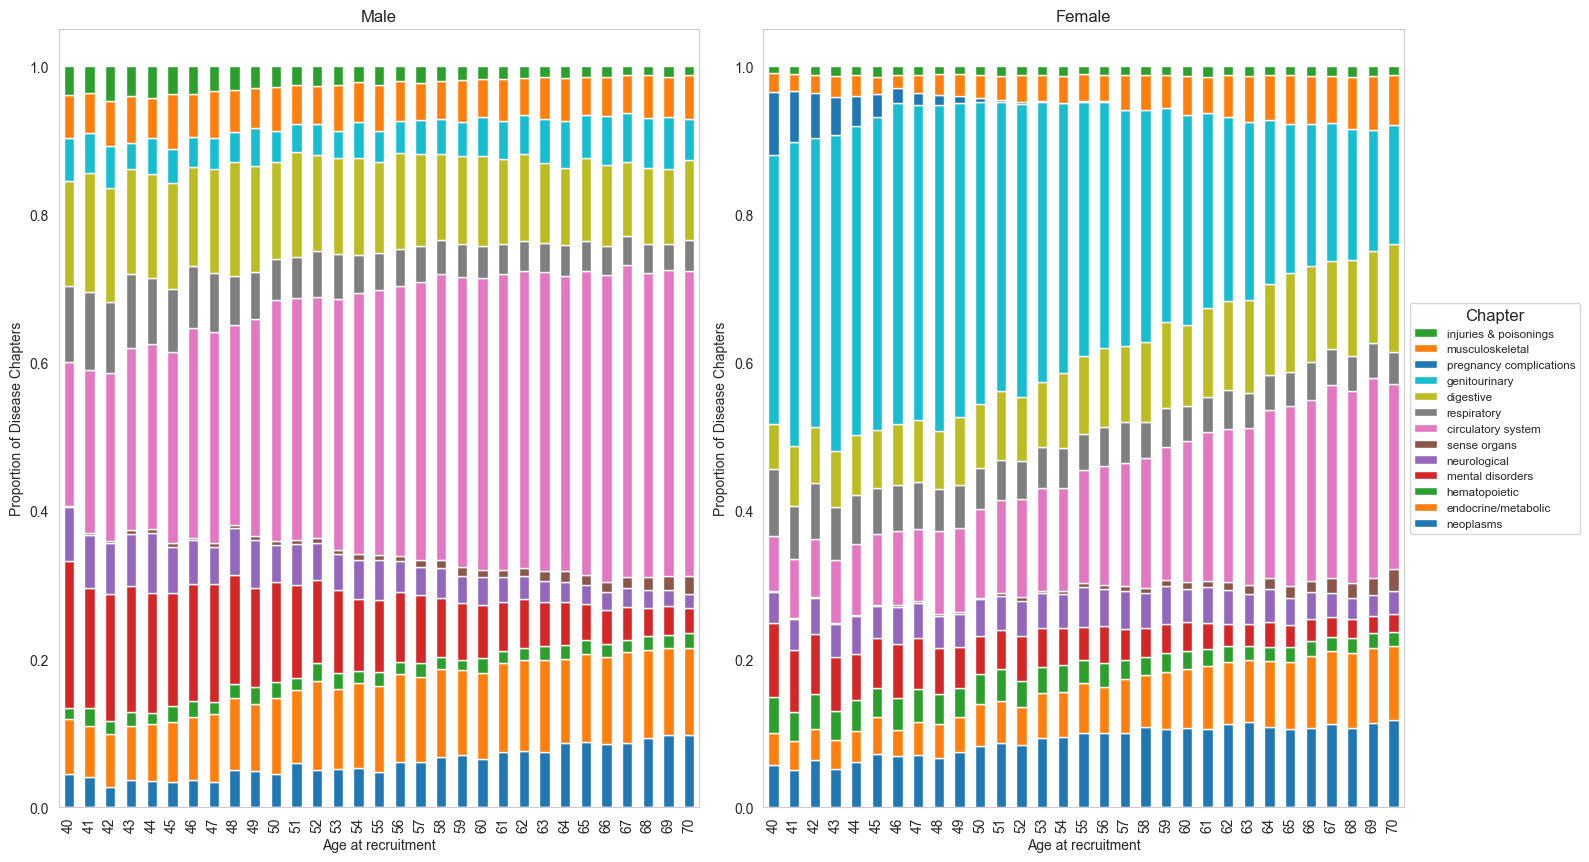

In [16]:
# 2.2.2 relative counts of the diseases
df_plot_2['total_diseases'] = df_plot_2[[f'chapter_{x}' for x in chapter_ranges]].sum(axis=1)
# Calculate the proportion of each chapter
for column in chapter_ranges:
    df_plot_2[f'chapter_{column}_prop'] = df_plot_2[f'chapter_{column}']/df_plot_2['total_diseases']

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [16,9]
# Create a subset of the dataframe with only the columns to be plotted
gender = 'Male'
df_subset = df_plot_2[df_plot_2['31'] == gender][['21022'] + [f'chapter_{i}_prop' for i in chapter_ranges]]
# Set '21022' as the index to be used as x-axis
df_subset.set_index('21022', inplace=True)

# Plot the stacked bar chart
df_subset.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title(gender)
ax1.set_xlabel('Age at recruitment')
ax1.set_ylabel('Proportion of Disease Chapters')
# remove the legend
ax1.get_legend().remove()


gender = 'Female'
df_subset = df_plot_2[df_plot_2['31'] == gender][['21022'] + [f'chapter_{i}_prop' for i in chapter_ranges]]
# Set '21022' as the index to be used as x-axis
df_subset.set_index('21022', inplace=True)

# Plot the stacked bar chart
df_subset.plot(kind='bar', stacked=True,  ax=ax2)
ax2.set_title(gender)
ax2.set_xlabel('Age at recruitment')
ax2.set_ylabel('Proportion of Disease Chapters')

handles, labels = ax2.get_legend_handles_labels()  # reverse the order of legend
labels = [phe_cate_dict[int(str(x).replace('chapter_','').replace('_prop',''))] for x in labels]
ax2.legend(reversed(handles), reversed(labels), title='Chapter', title_fontsize='large', fontsize='small', loc='center left', bbox_to_anchor=(1.0, 0.5))


for ax in [ax1, ax2]:
    ax.grid(False)
#fig.suptitle('Diseases chapter count by age and gender (Proportion)')
fig.tight_layout(rect=[0, 0.01, 1, 0.98])
# plt.show()

plt.savefig(params.current_path.parents[1]/f'plot/{level}/diseases_chapter_{record_column}_proportion_by_age_and_gender{"_weighted" if weight_control else ""}.pdf')


# disease occurrence


## within chapter (self-repeating rate)


/var/folders/04/q8s7l0r939g8fqqljjn3_rbm0000gn/T/ipykernel_48224/2908084431.py:6: FutureWarning: The provided callable <function mean at 0x7fb428478dc0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_to_plot = df_to_plot.pivot_table(index=['31','21022'],values=[f'chapter_{x}' for x in chapter_ranges],aggfunc=np.mean)


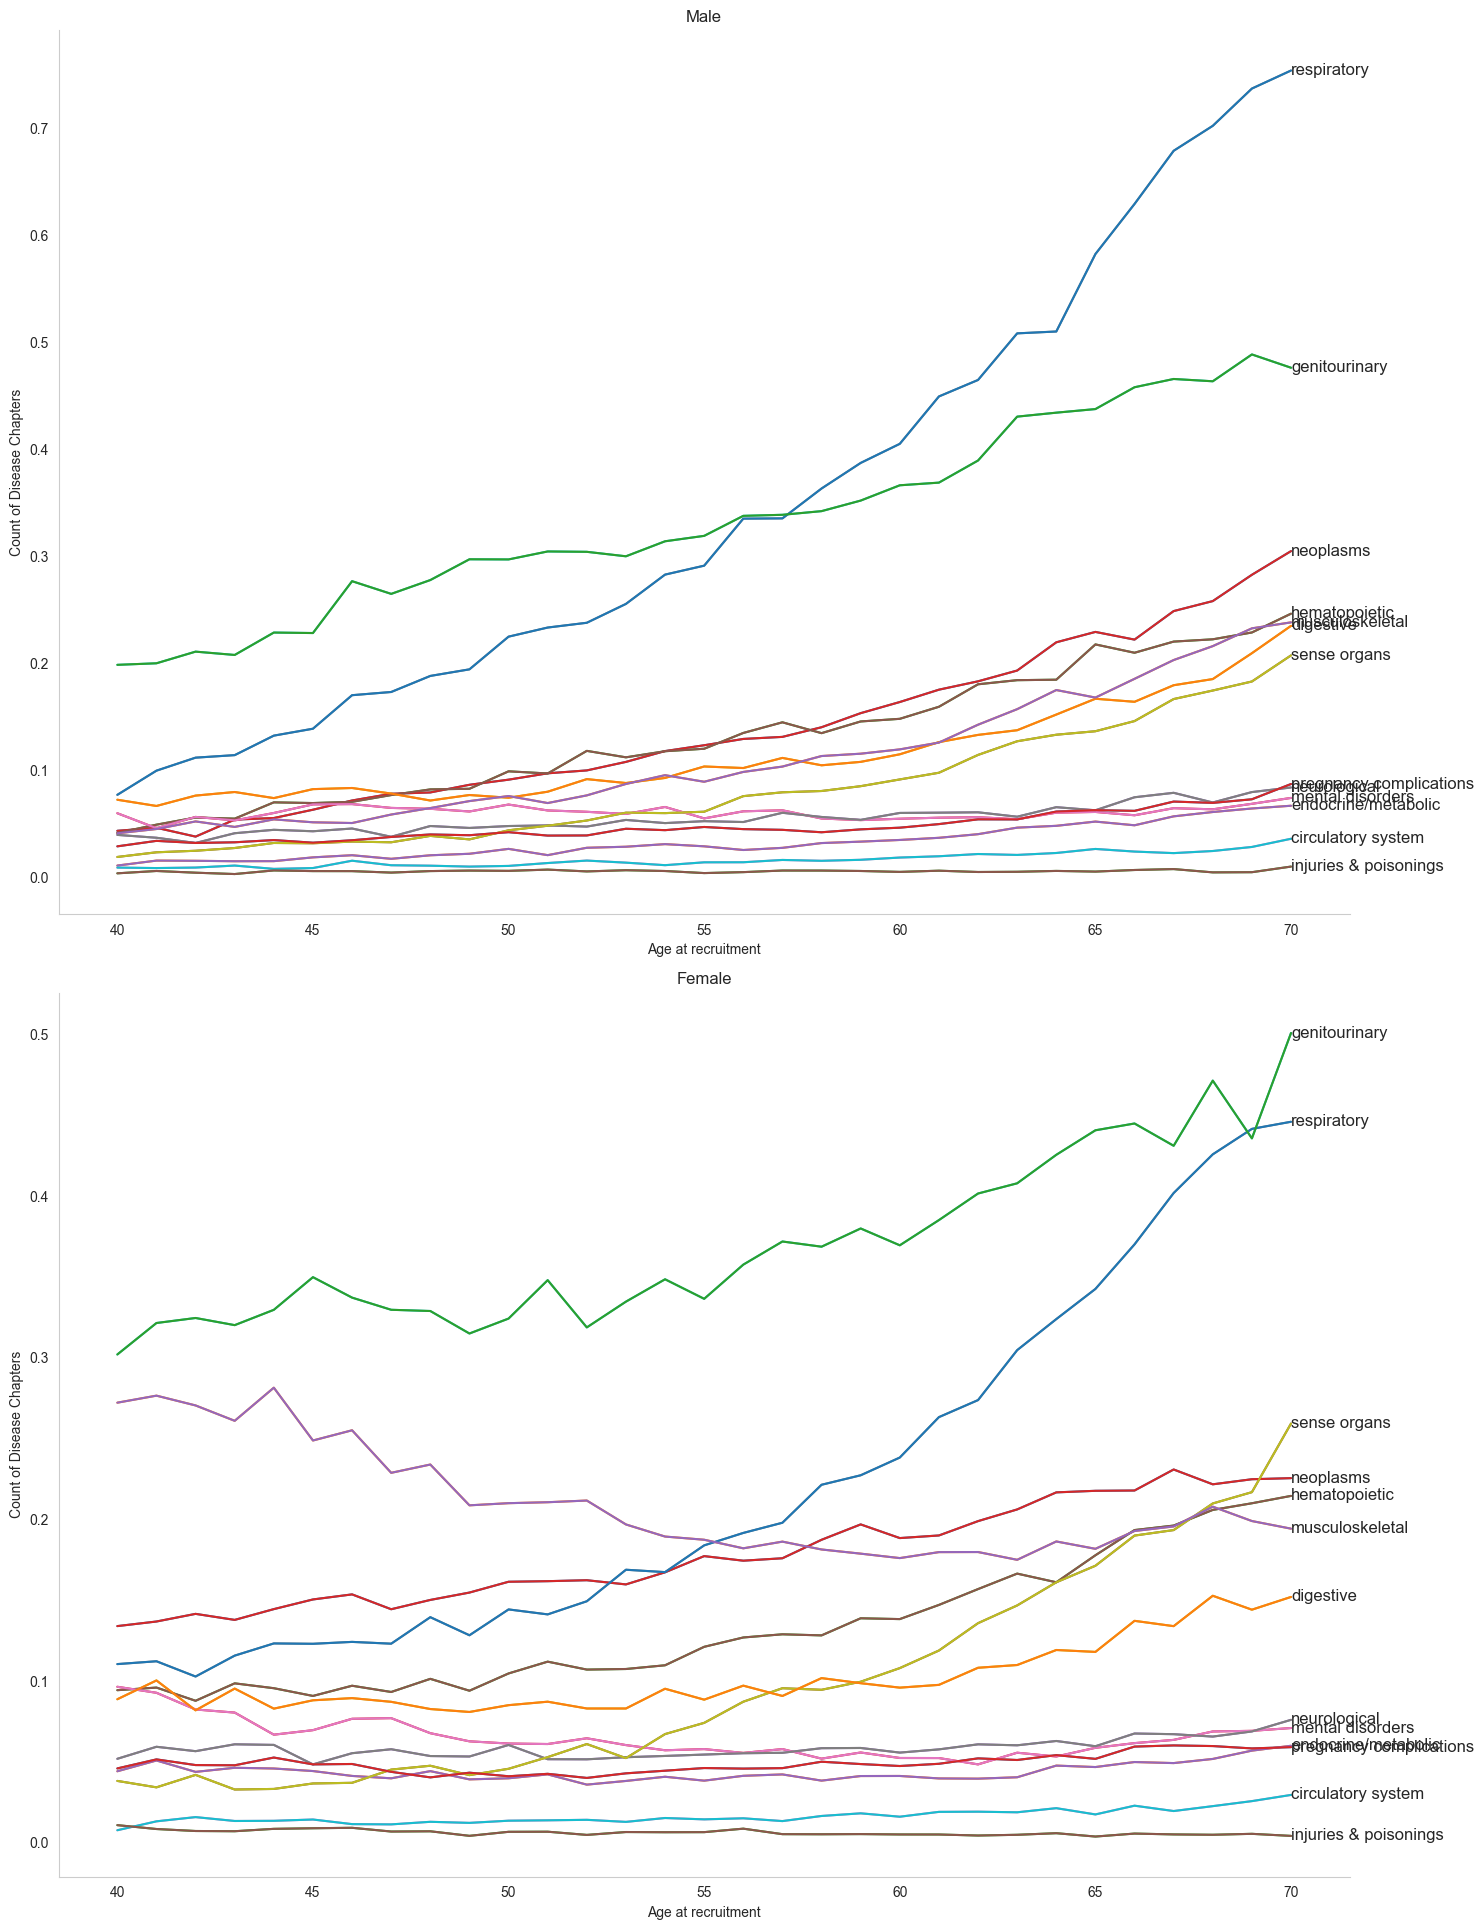

In [18]:


# self-repeating occurrence
# diseases related vars ['disease_count', 'chapter_1-22']

df_to_plot = df[['31', '21022']+[f'chapter_{x}' for x in chapter_ranges]]

df_to_plot = df_to_plot.pivot_table(index=['31','21022'],values=[f'chapter_{x}' for x in chapter_ranges],aggfunc=np.mean)
df_to_plot.reset_index(inplace=True)
df_to_plot.drop(df_to_plot.loc[(df_to_plot['21022'] < 40) | (df_to_plot['21022'] > 70)].index, inplace=True)

# set 31 as categorical variable
df_to_plot['31'] = df_to_plot['31'].astype('category')
df_to_plot['31'] = df_to_plot['31'].cat.rename_categories(['Female', 'Male'])

# remove diseases chapters that are bigger than 15

# within disease co-occurrence plot
fig, (ax1, ax2) = plt.subplots(2, 1)
plt.rcParams["figure.figsize"] = [15, 20]

gender = 'Male'
df_subset = df_to_plot[df_to_plot['31'] == gender][['21022'] + [f'chapter_{i}' for i in chapter_ranges]]
df_subset.set_index('21022', inplace=True)
df_subset.plot(kind='line', ax=ax1)
ax1.set_title(gender)
ax1.set_xlabel('Age at recruitment')
ax1.set_ylabel('Count of Disease Chapters')
for column in df_subset.columns:
    line = ax1.plot(df_subset.index, df_subset[column], label=column)
    last_x, last_y = df_subset.index[-1], df_subset[column].iloc[-1]
    ax1.text(last_x, last_y, phe_cate_dict[int(f'{column}'.replace('chapter_',''))], fontsize=12, verticalalignment='center')
ax1.legend().set_visible(False)

gender = 'Female'
df_subset = df_to_plot[df_to_plot['31'] == gender][['21022'] + [f'chapter_{i}' for i in chapter_ranges]]
df_subset.set_index('21022', inplace=True)
df_subset.plot(kind='line',  ax=ax2)
ax2.set_title(gender)
ax2.set_xlabel('Age at recruitment')
ax2.set_ylabel('Count of Disease Chapters')
for column in df_subset.columns:
    line = ax2.plot(df_subset.index, df_subset[column], label=column)
    last_x, last_y = df_subset.index[-1], df_subset[column].iloc[-1]
    ax2.text(last_x, last_y, phe_cate_dict[int(f'{column}'.replace('chapter_',''))], fontsize=12, verticalalignment='center')
ax2.legend().set_visible(False)

ax1.spines[['right', 'top' ]].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
# fig.suptitle(f'Diseases self-repeating rate by chapter {"(weighted)" if weight_control else ""}')
fig.tight_layout(rect=[0, 0.01, 1, 0.98])
# plt.show()
for ax in [ax1, ax2]:
    ax.grid(False)
plt.savefig(params.current_path.parents[1]/f'plot/{level}/disease_co_occurrence_{record_column}_within_diseases_by_chapter_chronic.pdf')


##  co-occurrence: between diseases (by each chapter)


/var/folders/04/q8s7l0r939g8fqqljjn3_rbm0000gn/T/ipykernel_48224/2292964830.py:48: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  co_occurrence_df = co_occurrence_df.applymap(lambda x: 0 if x<threshold*sum(sum(co_occurrence_df.values))else x)


neoplasms
endocrine/metabolic
mental disorders
neurological
circulatory system
respiratory
digestive
genitourinary
musculoskeletal
neoplasms circulatory system 14754
neoplasms digestive 7538
neoplasms genitourinary 10111
endocrine/metabolic mental disorders 7750
endocrine/metabolic circulatory system 64314
endocrine/metabolic digestive 8881
endocrine/metabolic genitourinary 9554
mental disorders circulatory system 22869
neurological circulatory system 8661
circulatory system respiratory 15192
circulatory system digestive 27553
circulatory system genitourinary 23476
circulatory system musculoskeletal 12071
digestive genitourinary 11707


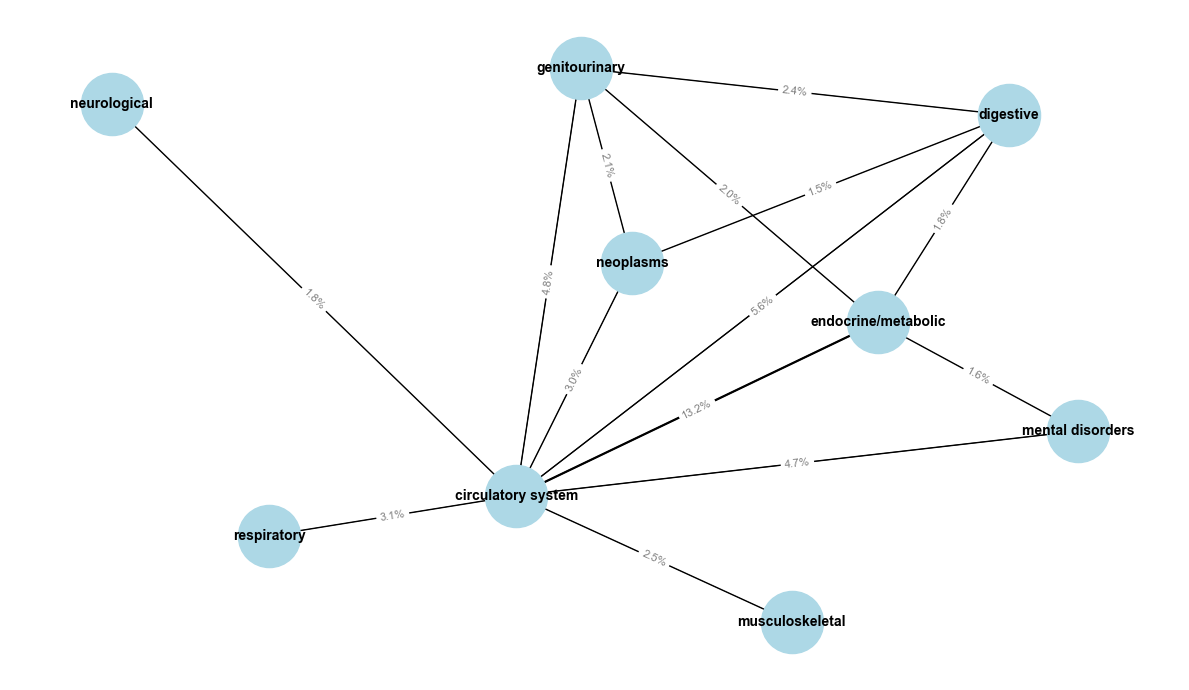

In [19]:
df_subset = df[[f'{level}_disease_count',disease_column, '31', '21022']].copy()
"""

# remove the chapters that we are less interested in
def remove_chapters_from_list(row,chapter_ranges):

    #remove the chapters that are not in the chapter_ranges

    if str(row) != 'None':
        chapters = row
        chapters = [x for x in chapters if x in chapter_ranges]
    else:
        chapters = None
    return chapters
df_subset[disease_column] = df_subset[disease_column].apply(lambda x: remove_chapters_from_list(x, chapter_ranges))

"""
# update the diesease count
if weight_control:
    df_subset[f'disease_count'] = [len(x)*weight if str(x) not in params.nan_str  else 0 for x,weight in zip(df[disease_column],df['weight'])]
else:
    df_subset[f'disease_count'] = [len(x) if str(x) not in params.nan_str else 0 for x in df[disease_column]]


# Sample data: list of transactions
dataset = [x for x in df_subset[disease_column].tolist() if str(x)!='None']

transaction_frequencies = [Counter(transaction) for transaction in dataset]

# Get all unique items
all_items = sorted(set(item for transaction in dataset for item in transaction))

# Create a frequency matrix where rows are transactions and columns are items
frequency_matrix = pd.DataFrame([{item: count[item] for item in all_items} for count in transaction_frequencies],
                                columns=all_items).fillna(0)


co_occurrence_matrix = np.dot(frequency_matrix.T, frequency_matrix)

# Set diagonal to zero to remove self-loops (optional, if you don't want self-links)
np.fill_diagonal(co_occurrence_matrix, 0)

# Convert to DataFrame for easier interpretation
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=frequency_matrix.columns, columns=frequency_matrix.columns)

threshold = 0.01
# replace the value below the threshold with 0
co_occurrence_df = co_occurrence_df.applymap(lambda x: 0 if x<threshold*sum(sum(co_occurrence_df.values))else x)
co_occurrence_df.columns = [phe_cate_dict[int(x)] for x in co_occurrence_df.columns]

# Step 2: Create a network graph using NetworkX
G = nx.Graph()

# Add nodes (items)
for item in co_occurrence_df.columns:
    if sum(co_occurrence_df[item]) > 0:
        print(item)
        G.add_node(item)

edge_set = set()
# Add edges (co-occurrences) if the co-occurrence value is greater than 0
for i, item1 in enumerate(co_occurrence_df.columns):
    for j, item2 in enumerate(co_occurrence_df.columns):
        if co_occurrence_df.iloc[i, j] > 0:
            edge_set.add((item1, item2))
            if (item2, item1) not in edge_set:
                print(item1, item2, co_occurrence_df.iloc[i, j])
                G.add_edge(item1, item2, weight=round(co_occurrence_df.iloc[i, j]/sum(sum(co_occurrence_df.values)),3))

# remove edges with weight less than 0.02
G.remove_edges_from([(u, v) for u, v, d in G.edges(data=True) if d['weight'] < 0.01])

# Step 3: Visualize the network
fig, ax = plt.subplots(figsize=(12,7))
pos = nx.spring_layout(G,seed=1234)  # Layout for visualization
pos["circulatory system"][1] = pos["circulatory system"][1]-0.5
pos["circulatory system"][0] = pos["circulatory system"][0]-0.2

pos["genitourinary"][1] = pos["circulatory system"][1]+1.5
pos["neoplasms"][0] = pos["neoplasms"][0]+0.5

pos["digestive"][0] = pos["digestive"][0]+0.3
pos["digestive"][1] = pos["digestive"][1]+0.3


nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold', ax=ax)
edge_labels = nx.get_edge_attributes(G, 'weight')

edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[d['weight']*12 for u, v, d in edges],ax=ax)
nx.draw_networkx_edge_labels(G, pos, edge_labels={x: f'{round(y * 100, 2)}%' for x,y in edge_labels.items()}, font_color='grey', font_size=8,ax=ax)
# remove edges with weight less than 0.02
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)

# fig.suptitle('Disease Chapter Co-occurrence Network View')
fig.tight_layout()

# plt.show()

plt.savefig(params.current_path.parents[1]/f'plot/{level}/disease_co_occurrence_between_diseases_by_{level}_{record_column}_{"_weighted" if weight_control else ""}.pdf')
